## Make necessary imports

In [1]:
import sys
sys.path.insert(0, '../')
import pandas as pd
import numpy as np
np.set_printoptions(precision=3, linewidth=200, suppress=True)
from library.datasets.cifar10 import CIFAR10
from library.plot_tools import plot_tools
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.externals import joblib
import time
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sklearn.metrics as skm
import matplotlib.pyplot as plt
from library.utils import file_utils
from scipy.misc import toimage
%matplotlib inline

None


In [2]:
from sklearn.neural_network import MLPClassifier
from library.hog.hog import HOG

In [3]:
total_time = 0
mlp_max_iter = 10000

In [4]:
search_method = 'grid'
scale_method = 'StandardScaler'
exp_jobs = 5
num_images_required = 0.3
train_validate_split_data = None
num_folds = 10
train_validate_split = 0.2
data_source = 'Website'
exp_no = 103
one_hot = True
file_no = 8
output_directory = '../logs/cifar10/' + str(file_no).zfill(2) + '_mlp_hog_cross_val/' + 'exp_no_' + str(exp_no).zfill(3) + '/'

In [5]:
param_grid = [
  {'hidden_layer_sizes': [(4000, 4000), (10000, 10000)], 
   'solver': ['lbfgs', 'adam'],
   'alpha': [1e-5, 1e-6, 1e-7]
  },
 ]
param_name = 'exp_' + str(exp_no).zfill(3)

In [6]:
block_size = (8,8)
cell_size = (2,2)
nbins = 9

## Step 0.1,2: Load CIFAR 10 HOG dataset and visualize CIFAR 10 dataset

In [7]:
start = time.time()
cifar10 = CIFAR10(one_hot_encode=one_hot, num_images=num_images_required, image_mode='grey',
                  train_validate_split=train_validate_split_data, endian='little')
cifar10.load_data(train=True, test=True, data_directory='./datasets/cifar10/')
end = time.time()
print('[ Step 0] Dataset loaded in %5.6f ms' %((end-start)*1000))
print('Dataset size: ' + str(cifar10.train.data.shape))
num_train_images = cifar10.train.data.shape[0]
total_time += (end-start)

Loading CIFAR 10 Dataset
MD5sum of the file: ./datasets/cifar10/cifar-10.tar.gz is verified
Loading 15000 train images
Loading CIFAR 10 Training Dataset
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_1
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_2
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_3
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_4
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_5
Loading 10000 test images
Loading CIFAR 10 Test Dataset
Unpickling test file: ./datasets/cifar10/cifar-10-batches/test_batch
Reading unpicked test file: ./datasets/cifar10/cifar-10-batches/test_batch
Loaded CIFAR 10 Dataset in 5.1228 seconds
[ Step 0] Dataset loaded in 5123.564243 ms
Dataset size: (15000, 3072)


Plotting CIFAR 10 Train Dataset


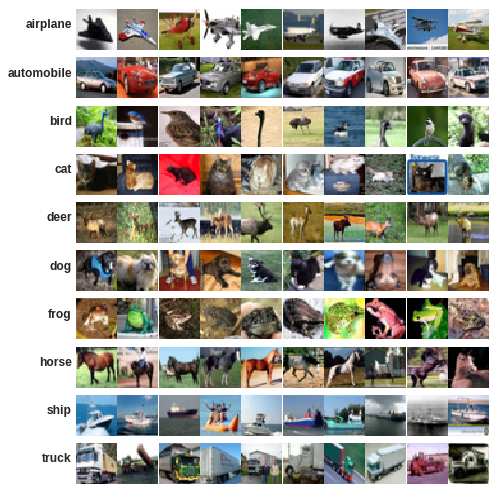

Plotting CIFAR 10 Test Dataset


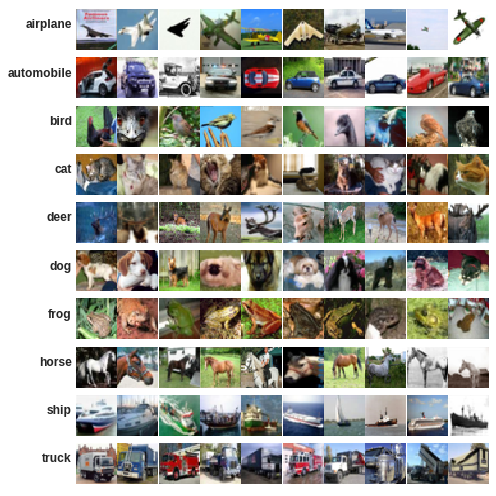

In [8]:
cifar10.plot_sample(plot_data=True, plot_test=True, fig_size=(7, 7))

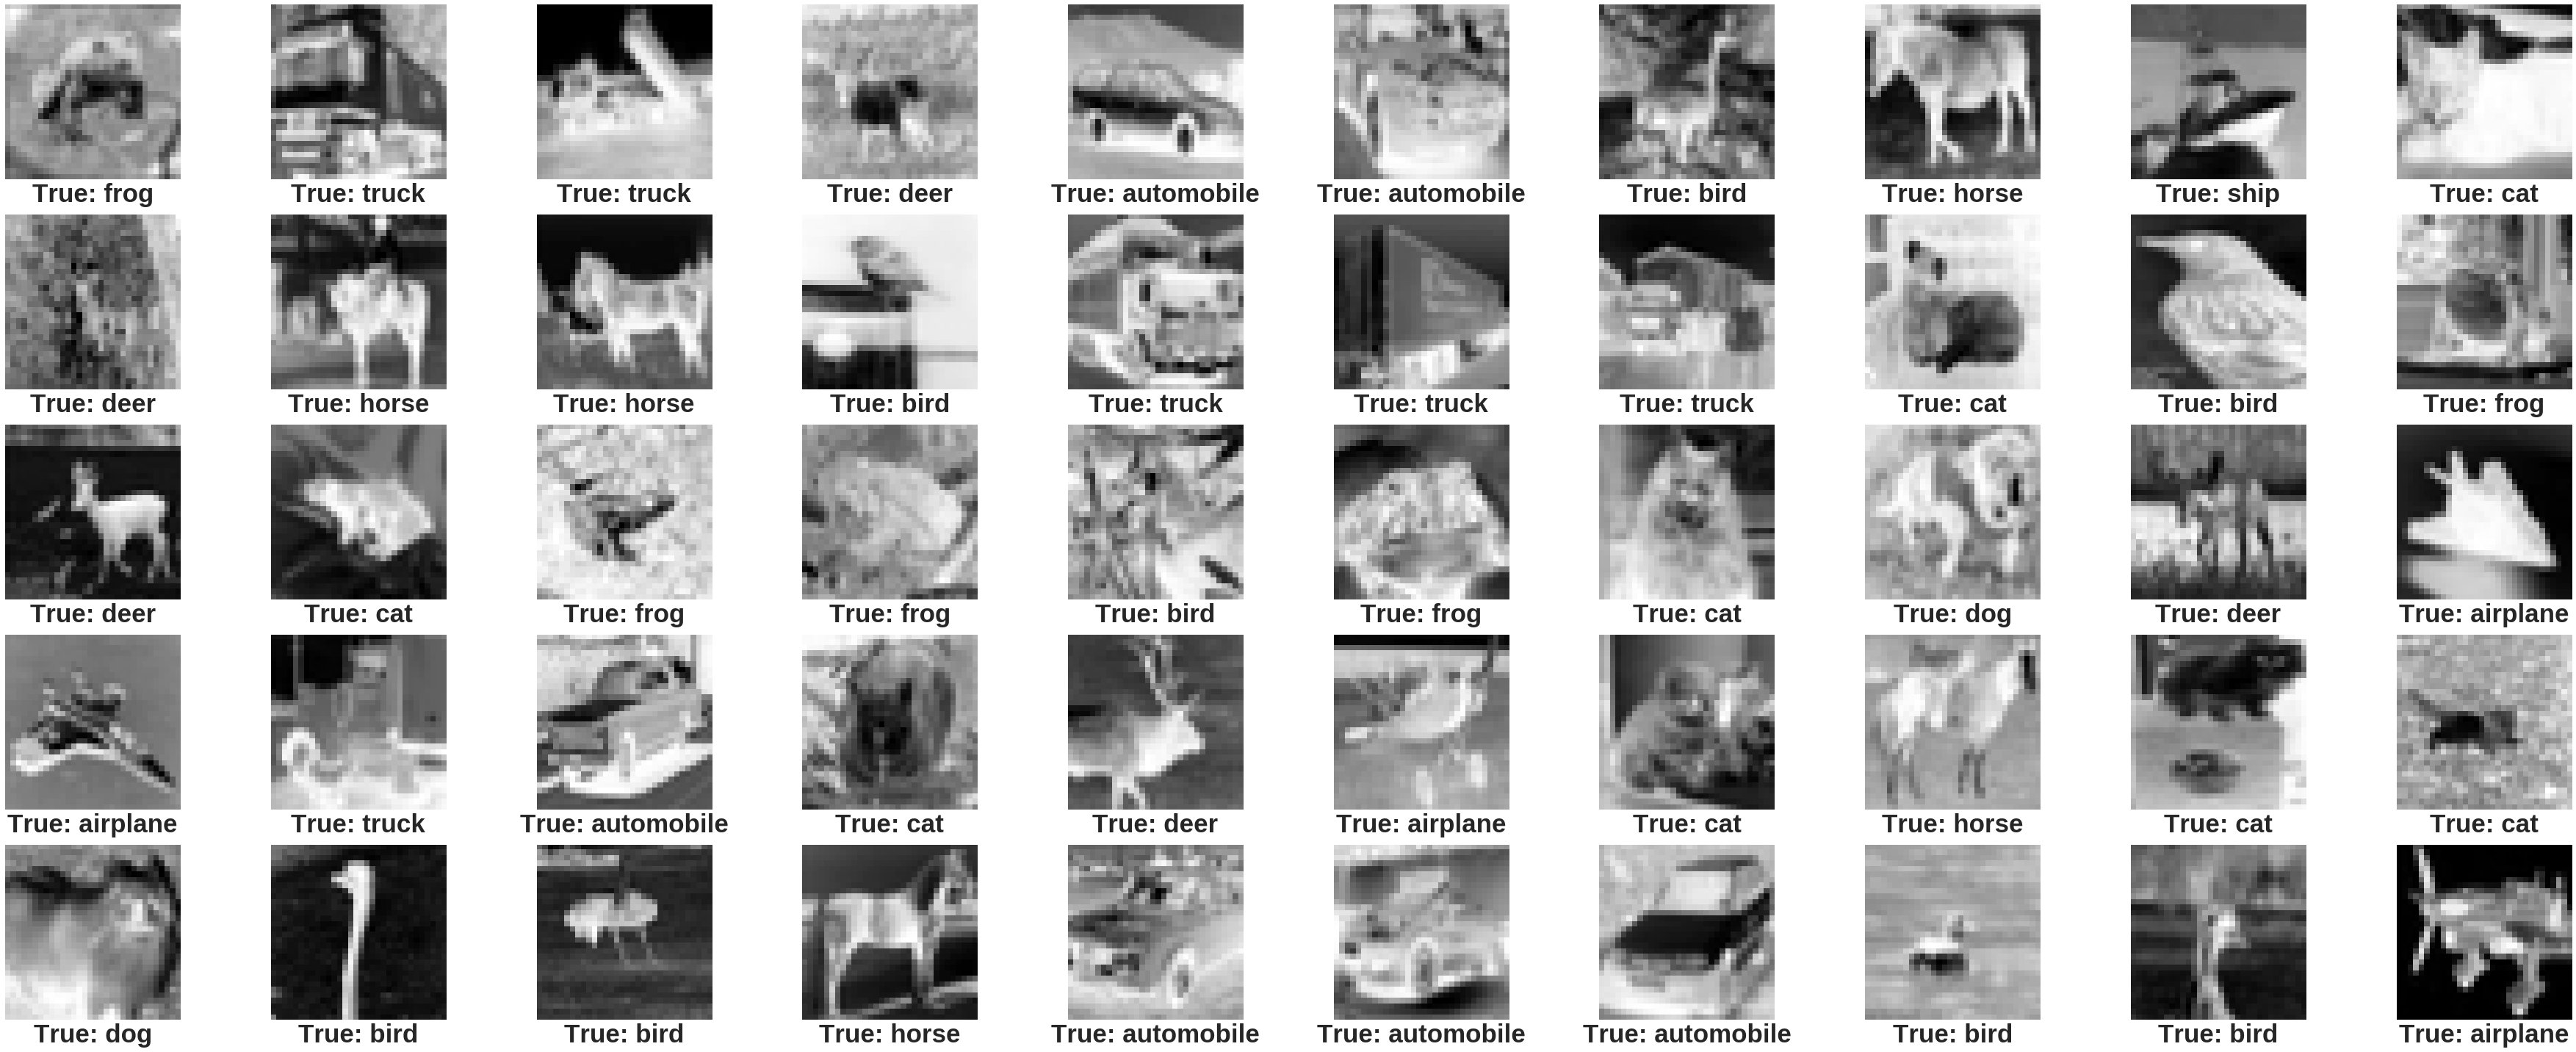

True

In [9]:
cifar10.plot_images(cifar10.train.images[:50, :], cifar10.train.class_names[:50], 
                    nrows=5, ncols=10, fig_size=(20,50), fontsize=35, convert=False)

In [10]:
start = time.time()
data_hog = []
feature_size = 0
print('Block size     : ' + str(block_size))
print('Cell size      : ' + str(cell_size))
print('Number of bins : ' + str(nbins))
hog = HOG(block_size=block_size, cell_size=cell_size, nbins=nbins)
print('Generating HOG features for %d data images' %cifar10.train.images.shape[0])
for fig_num in range(cifar10.train.images.shape[0]):
    img = cifar10.train.images[fig_num, :]
    gradients = hog.make_hog_gradients(img.astype('uint8'))
    data_hog.append(gradients.flatten())
    feature_size = gradients.size
data_hog = np.array(data_hog)
print('HOG Features for data: ' + str(data_hog.shape))
end = time.time()
print('Generated HOG for train images in %.6f ms' %((end-start)*1000))

Block size     : (8, 8)
Cell size      : (2, 2)
Number of bins : 9
Generating HOG features for 15000 data images
HOG Features for data: (15000, 2304)
Generated HOG for train images in 11779.337645 ms


In [11]:
start = time.time()
test_hog = []
feature_size = 0
print('Generating HOG features for %d test images' %cifar10.test.images.shape[0])
for fig_num in range(cifar10.test.images.shape[0]):
    img = cifar10.test.images[fig_num, :]
    gradients = hog.make_hog_gradients(img.astype('uint8'))
    test_hog.append(gradients.flatten())
    feature_size = gradients.size
test_hog = np.array(test_hog)
print('HOG Features for test: ' + str(test_hog.shape))
end = time.time()
print('Generated HOG for test images in %.6f ms' %((end-start)*1000))

Generating HOG features for 10000 test images
HOG Features for test: (10000, 2304)
Generated HOG for test images in 7697.166204 ms


## Step 2: Preprocess data

In [12]:
start = time.time()
if scale_method == 'StandardScaler':
    ss = StandardScaler()
elif scale_method == 'MinMaxScaler':
    ss = MinMaxScaler()
else:
    ss = StandardScaler()
data_images = ss.fit_transform(data_hog)
test_images = ss.fit_transform(test_hog)
end = time.time()
print('[ Step 1] Dataset transformations done in %5.6f ms' %((end-start)*1000))
print('Training the classifier on %d images' % num_train_images)
print('Dataset size: ' + str(data_images.shape))
total_time += (end-start)

[ Step 1] Dataset transformations done in 711.054325 ms
Training the classifier on 15000 images
Dataset size: (15000, 2304)


## Step 3: Parameters for estimatinng best model in MLP

In [13]:
print('Parameters to serach for')
print('\n'.join([str(param) for param in param_grid])); print()

Parameters to serach for
{'hidden_layer_sizes': [(4000, 4000), (10000, 10000)], 'solver': ['lbfgs', 'adam'], 'alpha': [1e-05, 1e-06, 1e-07]}



In [14]:
scores = []
scores_mean = []
scores_std = []

## Step 3.1: Run a search method for best parameters

In [ ]:
mlp_clf = MLPClassifier(random_state=0, max_iter=mlp_max_iter, verbose=True)
print(mlp_clf)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=True,
       warm_start=False)


In [ ]:
start = time.time()
if search_method == 'grid':
    print('Applying GridSearchCV')
    estimator = GridSearchCV(mlp_clf, param_grid, cv=num_folds, scoring='accuracy', verbose=3, n_jobs=exp_jobs)
elif serach_method == 'random':
    print('Applying RandomizedSearchCV')
    estimator = RandomizedSearchCV(mlp_clf, param_grid, cv=num_folds, scoring='accuracy', n_iter=10, 
                              random_state=0, verbose=3, n_jobs=exp_jobs)
else:
    print('Applying GridSearchCV')
    estimator = GridSearchCV(mlp_clf, param_grid, cv=num_folds, scoring='accuracy', verbose=3, n_jobs=exp_jobs)
print(estimator)
estimator_result = estimator.fit(data_images, cifar10.train.class_labels)
end = time.time()
total_time += (end-start)
print('Total Time taken for cross validation and finding best parameters: %.4f ms' %((end-start)*1000))

Applying GridSearchCV
GridSearchCV(cv=10, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=True,
       warm_start=False),
       fit_params={}, iid=True, n_jobs=5,
       param_grid=[{'hidden_layer_sizes': [(4000, 4000), (10000, 10000)], 'solver': ['lbfgs', 'adam'], 'alpha': [1e-05, 1e-06, 1e-07]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=3)
Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV] alpha=1e-05, hidden_layer_sizes=(4000, 4000), solver=lbfgs ......
[CV] alpha=1e-05, hidden_layer_sizes=(4000, 4000), solver=lbfgs ...

In [ ]:
print('\n'.join('{}: {}'.format(k, v) for k, v in estimator.cv_results_.items())); print()
print('Scores for each set of parameters')
print('\n'.join([str(param) for param in estimator.grid_scores_])); print()
print('Best score')
print(estimator.best_score_); print()
print('Parameters corresponding to best score')
print(estimator.best_params_); print()

## Step 3.1.1 Plot error lines showing +/- std. errors of the scores

In [ ]:
means = estimator_result.cv_results_['mean_test_score']
stds = estimator_result.cv_results_['std_test_score']
params = estimator_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('%f (%f) with: %r' % (mean, stdev, param))

## Step 4: Save the generated model to file

In [ ]:
start = time.time()
file_utils.mkdir_p(output_directory)
model_output_path = output_directory + '08_' + param_name + '.pkl'
joblib.dump(estimator, model_output_path)
end = time.time()
print('[ Step 4] Write obtained model to %s in %.6f ms' %(model_output_path, ((end-start)*1000)))
total_time += (end-start)

In [ ]:
scores = []
exp = []
dict_key = ['train', 'test']
for key in dict_key:
    scores_list = []
    for i in range(num_folds):
        key_name = 'split' + str(i) + '_' + key + '_score'
        scores_list.append(estimator.cv_results_[key_name].tolist())
    scores.append(scores_list)
scores = np.array(scores)
means = np.mean(np.array(scores).T, axis=1)
stds = np.std(np.array(scores).T, axis=1)

In [ ]:
plot_tools.plot_variance(scores, means, stds, legend=['Training data', 'Validation data'], 
                         plot_title=['Train scores for best parameters for MLP using HOG features in CIFAR 10',
                                     'Validation scores for best parameters for MLP using HOG features in CIFAR 10'], 
                         fig_size=(800,600), 
                         plot_xlabel=['SVC Parameters', 'MLP Parameters'],
                         plot_ylabel=['Training accuracy of the model', 'Validation accuracy of the model'],
                         plot_lib='bokeh', 
                         matplotlib_style='default', bokeh_notebook=True)

## Step 5: Run the predictor on test data and generate predictions

In [ ]:
start = time.time()
prediction_numbers = estimator.predict(test_images)
prediction_classes = []
num_test_images = test_images.shape[0]
for i in range(num_test_images):
    prediction_classes.append(cifar10.classes[int(prediction_numbers[i])])
end = time.time()
print('[ Step 9] Make prediction on test dataset in %.6f ms' %((end-start)*1000))
total_time += (end-start)

In [ ]:
cifar10.plot_images(cifar10.test.images[:50], cifar10.test.class_names[:50], cls_pred=prediction_classes[:50], 
                    nrows=5, ncols=10, fig_size=(20,50), fontsize=35, convert=False)

## Step 5.1 Print accuracy score of the classifier

In [ ]:
start = time.time()
plot_tools.plot_confusion_matrix(cifar10.test.class_labels, prediction_numbers, classes=cifar10.classes,
                              normalize=True, title='Confusion matrix for test set using SVC for HOG features')
print(skm.classification_report(cifar10.test.class_labels, prediction_numbers, target_names=cifar10.classes))
test_accuracy = skm.accuracy_score(cifar10.test.class_labels, prediction_numbers, normalize=True)
print('Accuracy score on test data: ' + str(test_accuracy))
end = time.time()
total_time += (end-start)

In [ ]:
start = time.time()
print('Prediction done on %d images' %cifar10.test.data.shape[0])
print('Accuracy of the classifier: %.4f' %estimator.score(test_images, cifar10.test.class_labels))
end = time.time()
total_time += (end-start)

## Step 6: Write predictions to csv file

In [ ]:
start = time.time()
indices = np.arange(1, test_images.shape[0]+1)
predictions = np.column_stack((indices, prediction_classes))
file_utils.mkdir_p(output_directory)
output_csv_file = output_directory + '08_' + param_name + '.csv'
column_names = ['id', 'label']
predict_test_df = pd.DataFrame(data=predictions, columns=column_names)
predict_test_df.to_csv(output_csv_file, index=False)
end = time.time()
print('[ Step 6] Writing the test data to file: %s in %.6f ms' %(output_csv_file, (end-start)*1000))
total_time += (end-start)

## Step 7: Write predictions to HTML

In [ ]:
def output_HTML(read_file, output_file):
    from nbconvert import HTMLExporter
    import codecs
    import nbformat
    exporter = HTMLExporter()
    output_notebook = nbformat.read(read_file, as_version=4)
    print()
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

In [ ]:
%%javascript
var notebook = IPython.notebook
notebook.save_notebook()

In [ ]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

In [ ]:
current_file = './' + theNotebook + '.ipynb'
output_file = output_directory + str(file_no).zfill(2) + '_exp_no_' + str(exp_no) + '_' + theNotebook + '.html'
print('Current file: ' + str(current_file))
print('Output file: ' + str(output_file))
file_utils.mkdir_p(output_directory) 
output_HTML(current_file, output_file)

In [ ]:
print('Code took %.6f s to run on training with %d examples' % (total_time,num_train_images))